In [2]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import scipy as scipy
import time
%matplotlib inline

In [3]:
import os
os.chdir("D:/NYC Taxi/scripts")
trip_df = pd.read_csv('../input/trip_data_2.csv')
fare_df = pd.read_csv('../input/trip_fare_2.csv')
pcp_df = pd.read_csv('../input/nyc_hourly_pcp_2013.csv')

C:\Users\95780\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
from utils import haversine, manhattan, angle_abs, flatten

In [4]:
# Clean column names
fare_cols = fare_df.columns.tolist()
new_fare_cols = []
for col in fare_cols:
    new_fare_cols.append(col.lstrip().rstrip())
fare_df.columns = new_fare_cols

## Check order of obs
#for col in ['medallion', 'hack_license', 'pickup_datetime']:
#    print(all(trip_df[col] == fare_df[col])) # True, True, True

# Concat data
dupe_cols = ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime']
df = pd.concat([trip_df, fare_df.drop(dupe_cols, axis = 1)], axis = 1)
trip_df = None
fare_df = None

## Summary of Data

In [ ]:
df.dtypes

In [ ]:
df.describe()

In [5]:
df.vendor_id.value_counts()
df.rate_code.value_counts()
df.store_and_fwd_flag.value_counts()
df.passenger_count.value_counts() # found outliers of 0, 9, 208 and 255 passengers

1      9942847
2      1863442
5       842936
3       555313
6       525664
4       259761
0          202
7            5
9            2
8            2
208          1
129          1
Name: passenger_count, dtype: int64

## Initial Processing

In [5]:
len(df) #14776615

# Check for nulls
df.isnull().values.any()
df.isnull().sum(axis=0) #nulls in dropoff_latitude and dropoff_longitude

# Drop rows with null
cols_to_check = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'trip_time_in_secs', 'trip_distance']
df.dropna(axis=0, how='any', subset=cols_to_check, inplace=True)
# 14776529

# Limit range to Manhattan only
lat_lo, lat_hi = 40.70, 40.84
lon_lo, lon_hi = -74.02, -73.89

lat_lon_range = \
    (lat_lo < df.pickup_latitude) & (df.pickup_latitude < lat_hi) & \
    (lon_lo < df.pickup_longitude) & (df.pickup_longitude < lon_hi) & \
    (lat_lo < df.dropoff_latitude) & (df.dropoff_latitude < lat_hi) & \
    (lon_lo < df.dropoff_longitude) & (df.dropoff_longitude < lon_hi)
    
df = df[lat_lon_range] 
len(df) #12979519

# Limit passengers to 1, 71% of trips
df = df[df.passenger_count == 1]

# # Limit passenger to between 1 and 6
# df = df[(df.passenger_count >= 1) & (df.passenger_count <= 6)] # 12.98 million

## EDA

In [ ]:
# Univariate Viz
plt.hist(df[pd.notnull(df.fare_amount)]['fare_amount'], 100);

plt.hist(df.trip_time_in_secs, 100);

plt.boxplot(df.pickup_longitude);
plt.boxplot(df.pickup_latitude);
plt.hist(df.pickup_latitude, 100);

plt.hist(df['trip_time_in_secs'], 50);

# Boxplot of fare_amount
ax = sns.boxplot(x="fare_amount", data=df, color="c")
plt.xlim(0, 50)

plt.hist(df.fare_amount[df.fare_amount > 60].reshape(-1 ,1), 50)

# Quantile plot
counts, start, dx, _ = scipy.stats.cumfreq(df.fare_amount[df.fare_amount>50].as_matrix(),
                                           numbins=100)
x = np.arange(counts.size) * dx + start
plt.plot(x, counts, 'ro', markersize=4)

# Multivariate Viz
sns.jointplot(x="trip_time_in_secs", y="trip_distance", data=df,  alpha=.01);
df_weekday = df.pickup_weekday.value_counts();

#ggplot(df, aes(x='pickup_longitude', y='pickup_latitude')) + geom_point(alpha=.1)
plt.scatter(df.pickup_longitude, df.pickup_latitude, alpha=.01);
plt.axis([-74.2, -73.7, 40.56, 40.93]);

sns.jointplot(x='pickup_longitude', y='pickup_latitude', data=df, alpha=.005);


## Wrangling

In [6]:
# Datetime data
#df['pickup_date'] = df.pickup_datetime.str[0:4] + df.pickup_datetime.str[5:7] + df.pickup_datetime.str[8:10]
datetime_cols = ['pickup_datetime', 'dropoff_datetime']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

col = 'pickup_datetime'
df[col.split('_')[0] + '_weeknum'] = df[col].dt.week
df[col.split('_')[0] + '_weekday'] = df[col].dt.dayofweek
df[col.split('_')[0] + '_hour'] = df[col].dt.hour

df[col.split('_')[0] + '_minute'] = df[col].dt.minute
df[col.split('_')[0] + '_hr_min'] = df['pickup_hour'] * 60 + df['pickup_minute']

#df['trip_time_calc'] = (df.dropoff_datetime - df.pickup_datetime).astype('timedelta64[s]')

# Trip distance of 0
df[df.trip_distance == 0]

# Trip time of 0
df[df.trip_time_in_secs == 0]

# Clean
df = df[(df.trip_distance > 0) & (df.trip_time_in_secs > 0)]
len(df)

# Only look at trips with fare_amount/trip_distance ratio between 2 and 10
df['fare_per_mile'] = df.fare_amount/df.trip_distance
df = df[(df.fare_per_mile >= 2) & (df.fare_per_mile <= 10)]
len(df) # 12.47 million

# Only look at trips with 60 * fare_amount/trip_time_in_secs between 0.2 and 4
df['fare_per_min'] = (60 * df.fare_amount) / df.trip_time_in_secs
df = df[(df.fare_per_min >= .5) & (df.fare_per_min <= 2.5)] # or 0.2 to 4
#plt.hist(df.fare_per_min, 50);
len(df) # 12.46 million

# Fare greater than or equal to $2.50 (initial charge), less than or equal to $52
df = df[(df.fare_amount >= 2.5) & (df.fare_amount <= 52)]

# Trip time less than or equal to 1 hour
df = df[df.trip_time_in_secs <= 3600]

In [7]:
df['pickup_datetime_str'] = df['pickup_datetime'].astype(str) 
df['pickup_date'] = df['pickup_datetime_str'].str[:4] + \
                    df['pickup_datetime_str'].str[5:7] + \
                    df['pickup_datetime_str'].str[8:10]

In [304]:
# Focus only on Manhattan using json boundaryfile
import json
with open('../input/Borough Boundaries.geojson') as data_file:    
    data = json.load(data_file)

In [332]:
for area in data['features']:
    if area['properties']['boroname'] == 'Manhattan':
        poly_manhattan = area['geometry']['coordinates']
poly_manhattan

[[[[-74.01092841268037, 40.68449147254297],
   [-74.01193259911066, 40.683887749155005],
   [-74.01217596614643, 40.684095185628514],
   [-74.00878590130927, 40.68614660229891],
   [-74.00869559889554, 40.68619331801266],
   [-74.0085980332972, 40.686252564085],
   [-74.00835446532182, 40.68640020025072],
   [-74.00816414593918, 40.6861747171615],
   [-74.00842516151936, 40.68601553244516],
   [-74.00851294257353, 40.68596254908626],
   [-74.00860072436839, 40.685909564654835],
   [-74.01092841268037, 40.68449147254297]]],
 [[[-74.00500373315083, 40.68760598540088],
   [-74.00562986330407, 40.686784206043654],
   [-74.0078329376669, 40.68738505516276],
   [-74.00742012154103, 40.688206290435936],
   [-74.00500373315083, 40.68760598540088]]],
 [[[-74.0038203891974, 40.68892964469932],
   [-74.00459270521779, 40.68821522298662],
   [-74.00678438439817, 40.6888268799583],
   [-74.00636461225274, 40.689669668637],
   [-74.0038203891974, 40.68892964469932]]],
 [[[-74.00297565436573, 40.6904

In [333]:
import matplotlib.path as mplPath
bbPath = mplPath.Path(np.array(poly_manhattan))


ValueError: setting an array element with a sequence.

In [8]:
# Precipitation Data
pcp_df.drop(['STATION', 'STATION_NAME'], axis=1, inplace=True)

In [9]:
# Hourly precipitation data
col = 'DATE'
pcp_df['pickup_date'] = pcp_df[col].str.split(' ').str[0]

pcp_df[col] = pd.to_datetime(pcp_df[col], format='%Y%m%d %H:%M')
pcp_df['pickup_hour'] = pcp_df[col].dt.hour

In [10]:
# Merge 
df = pd.merge(df, pcp_df[['pickup_date', 'pickup_hour', 'HPCP']], how='left', on=['pickup_date', 'pickup_hour']).fillna(0)
df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,pickup_weeknum,pickup_weekday,pickup_hour,pickup_minute,pickup_hr_min,fare_per_mile,fare_per_min,pickup_datetime_str,pickup_date,HPCP
0,1B5C0970F2AE8CFFBA8AE4584BEAED29,D961332334524990D1BBD462E2EFB8A4,CMT,1,N,2013-02-08 23:35:14,2013-02-08 23:42:58,1,463,0.8,...,6,4,23,35,1415,7.500000,0.777538,2013-02-08 23:35:14,20130208,7
1,890699222C47C09FBC898758CEC69762,6318C3AEC02248928C3345B5805EB905,CMT,1,N,2013-02-08 08:56:54,2013-02-08 08:59:43,1,168,1.0,...,6,4,8,56,536,5.000000,1.785714,2013-02-08 08:56:54,20130208,3
2,74B7D835C2CD98606D5256DA8A38E045,D5E278C918256D1F97680A1F04D290E0,CMT,1,N,2013-02-08 09:37:02,2013-02-08 09:50:50,1,828,2.1,...,6,4,9,37,577,5.238095,0.797101,2013-02-08 09:37:02,20130208,3
3,4003B8478418FEC5D761E2F37602769B,0B766F1054A5C16D86BC023858BD8143,CMT,1,N,2013-02-08 19:31:25,2013-02-08 19:46:23,1,897,3.3,...,6,4,19,31,1171,3.939394,0.869565,2013-02-08 19:31:25,20130208,2
4,FA5337E245DE9B2E124AFA735B41B4DF,6E6B7D73303D5AE3808A9ABF4D3FF65B,CMT,1,N,2013-02-07 22:02:30,2013-02-07 22:06:18,1,227,0.7,...,6,3,22,2,1322,7.142857,1.321586,2013-02-07 22:02:30,20130207,0


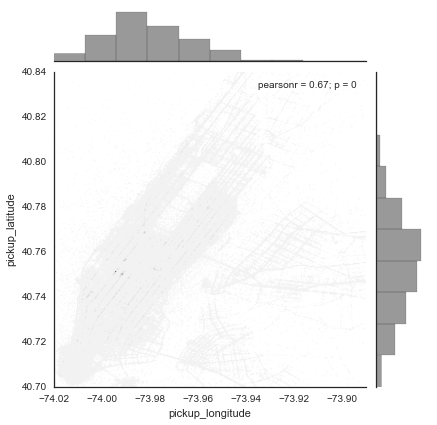

In [337]:
with sns.axes_style("white"):
    sns.jointplot(x=df.pickup_longitude, y=df.pickup_latitude, kind="hex", color="k",
                  joint_kws={'bins':20}, marginal_kws={'bins': 10});

## Feature Engineering

In [12]:
# Distance in KM
km_per_mi = 1.61
df['trip_distance_km'] = df.trip_distance * km_per_mi

# Average Speed
df['avg_speed'] = 3600 * (df.trip_distance_km / df.trip_time_in_secs)

# Angle of direction from pickup to dropoff
df['angle_abs'] = np.vectorize(angle_abs)(df.pickup_longitude, df.pickup_latitude,
                                          df.dropoff_longitude, df.dropoff_latitude)
                                       
# Haversine Distance
df['h_dist'] = np.vectorize(haversine)(df.pickup_longitude, df.pickup_latitude,
                                       df.dropoff_longitude, df.dropoff_latitude)
                    
# Manhattan Distance
df['m_dist'] = np.vectorize(manhattan)(df.pickup_longitude, df.pickup_latitude,
                                       df.dropoff_longitude, df.dropoff_latitude)

## Counts for high cardinal columns
#plt.plot(df.medallion.value_counts());
#plt.axis([20, 200, 100, 2000]); # retain top 40
#
#plt.plot(df.hack_license.value_counts());
#plt.axis([0, 2000, 100, 2000]); # retain top 120

In [13]:
# Round off to two decimal for lat and lon, appprox 1.11km
for col in ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude']:
    df[col + '2'] = df[col] - .005
    df[col + '2'] = df[col + '2'].round(2)
    
# That time of day
def getThatTimeOfDay(hour):
    if hour >= 5 and hour <= 9:
        return 'Morning'
    elif hour >= 10 and hour <= 11:
        return "Mid-morning"
    elif hour >= 12 and hour <= 15:
        return "Afternoon"
    elif hour >= 16 and hour <= 21:
        return "Evening"
    else:
        return "Night"
        
df['pickup_timeofday'] = df['pickup_hour'].map(getThatTimeOfDay)
pickup_timeofday_dummies = pd.get_dummies(df.pickup_timeofday, prefix = 'pickup')

df['zone'] = df['pickup_longitude2'].astype(str) + "_" + df['pickup_latitude2'].astype(str)
df['zone_hour'] = df['zone'].astype(str) + "_" + df['pickup_hour'].astype(str)
#zone_hour_to_retain = df['zone_hour'].value_counts()[0:500].index.tolist()
#df['zone_hour'] = df['zone_hour'].map(lambda x: x if x in zone_hour_to_retain else 'other_zone_hour')
#zone_hour_dummies

pickup_lon_dummies = pd.get_dummies(df.pickup_longitude2, prefix = 'pickup_lon')
pickup_lat_dummies = pd.get_dummies(df.pickup_latitude2, prefix = 'pickup_lat')
dropoff_lon_dummies = pd.get_dummies(df.pickup_longitude2, prefix = 'dropoff_lon')
dropoff_lat_dummies = pd.get_dummies(df.pickup_latitude2, prefix = 'dropoff_lat')

pickup_hour_dummies = pd.get_dummies(df.pickup_hour, prefix = 'pickup_hour')
pickup_weekday_dummies = pd.get_dummies(df.pickup_weekday, prefix = 'pickup_weekday')

In [14]:
df['HPCP2'] = df.HPCP.map(lambda x: 1 if x > 0 else 0)

In [15]:
dummy_cols = []
for var in [pickup_timeofday_dummies, pickup_lon_dummies, pickup_lat_dummies,
            dropoff_lon_dummies, dropoff_lat_dummies, pickup_weekday_dummies,
            pickup_hour_dummies]:
    dummy_cols.append(var.columns.tolist())
dummy_cols = list(flatten(dummy_cols))

df = pd.concat([df, pickup_lon_dummies, pickup_lat_dummies, dropoff_lon_dummies, dropoff_lat_dummies,
                pickup_weekday_dummies, pickup_timeofday_dummies, pickup_hour_dummies], axis=1)

# Is public holiday, is a day before public holiday

In [65]:
# Output file
#df.to_csv('../output/df.csv')

In [56]:
from sklearn.cluster import MiniBatchKMeans
X = df.fare_amount.as_matrix().reshape(-1, 1) # -1 will be calculated as the length
k_rng = range(3, 9)
n_clusters_tested = len(k_rng)

In [68]:
tot_within_sum_squares = np.array([0.] * n_clusters_tested)
n = 5
for i in range(n):
    est = [MiniBatchKMeans(n_clusters = k).fit(X) for k in k_rng]
    within_sum_squares = [e.inertia_ for e in est]
    tot_within_sum_squares += np.array(within_sum_squares)

avg_within_sum_squares = tot_within_sum_squares / float(n)
print(avg_within_sum_squares)

[ 34145290.14735541  23083266.25108504  14667760.94500309
  10551117.52967757   8574753.65004056   6912630.87249608]


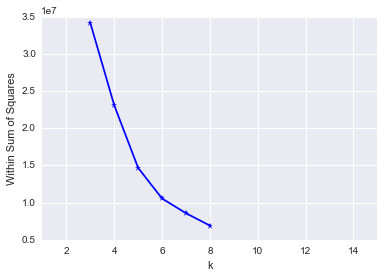

In [69]:
# Plot the results
plt.plot(k_rng, avg_within_sum_squares, 'b*-')
plt.xlim([1,9])
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Within Sum of Squares')
# Optimal 6 clusters (or 5)

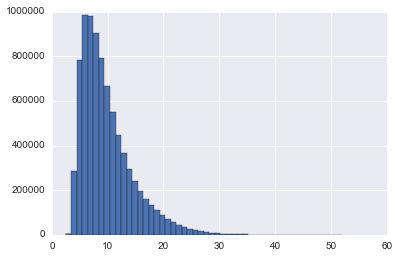

In [100]:
#sns.distplot(X, rug=True, bins=50);
plt.hist(df.fare_amount, 50);

In [69]:
# Examine average cost of routes using grids
df_avg_fare = \
    df.groupby(['pickup_latitude2', 'pickup_longitude2', 'dropoff_latitude2', 'dropoff_longitude2',
                'pickup_weekday', 'pickup_hour'])['fare_amount'].agg(['mean'])
df_avg_fare.reset_index(inplace=True)
df_avg_fare = df_avg_fare.sort(['pickup_latitude2', 'pickup_longitude2', 'dropoff_latitude2', 'dropoff_longitude2',
                                'pickup_weekday', 'pickup_hour'], ascending=True)
df_avg_fare.head(20)

,pickup_latitude2,pickup_longitude2,dropoff_latitude2,dropoff_longitude2,pickup_weekday,pickup_hour,mean
0,40.7,-74.02,40.7,-74.02,0,0,4.000000
1,40.7,-74.02,40.7,-74.02,0,1,5.000000
2,40.7,-74.02,40.7,-74.02,0,2,5.250000
3,40.7,-74.02,40.7,-74.02,0,6,4.944444
4,40.7,-74.02,40.7,-74.02,0,7,5.769231
5,40.7,-74.02,40.7,-74.02,0,8,6.775862
6,40.7,-74.02,40.7,-74.02,0,9,5.555556
7,40.7,-74.02,40.7,-74.02,0,10,6.557692
8,40.7,-74.02,40.7,-74.02,0,11,5.076923
9,40.7,-74.02,40.7,-74.02,0,12,6.565217


In [ ]:
# Examine common routes using grids
df_freq = \
    df.groupby(['pickup_latitude2', 'pickup_longitude2', 'dropoff_latitude2', 'dropoff_longitude2',
                'pickup_weekday', 'pickup_hour'])['total_amount'].agg(['count', 'sum'])
df_freq.reset_index(inplace=True)
#df_freq = df_freq.sort('count', ascending=False)
print(df_freq.head(10))
print(len(df_freq))

In [ ]:
df_freq['sum'] = (df_freq['sum'] * 12).astype(int)
df_freq.sort('count', ascending=False).head()

In [16]:
# Examine common routes using grids by week
df_freqw = \
    df.groupby(['pickup_latitude2', 'pickup_longitude2', 'dropoff_latitude2', 'dropoff_longitude2',
                'pickup_weeknum', 'pickup_weekday', 'pickup_hour'])['total_amount'].agg(['count', 'sum'])
df_freqw.reset_index(inplace=True)
#df_freq = df_freq.sort('count', ascending=False)
print(df_freqw.head(10))
print(len(df_freqw))

   pickup_latitude2  pickup_longitude2  dropoff_latitude2  dropoff_longitude2  \
0              40.7             -74.02               40.7              -74.02   
1              40.7             -74.02               40.7              -74.02   
2              40.7             -74.02               40.7              -74.02   
3              40.7             -74.02               40.7              -74.02   
4              40.7             -74.02               40.7              -74.02   
5              40.7             -74.02               40.7              -74.02   
6              40.7             -74.02               40.7              -74.02   
7              40.7             -74.02               40.7              -74.02   
8              40.7             -74.02               40.7              -74.02   
9              40.7             -74.02               40.7              -74.02   

   pickup_weeknum  pickup_weekday  pickup_hour  count    sum  
0               5               4            

In [17]:
df= pd.merge(df, df_freqw, on=['pickup_latitude2', 'pickup_longitude2', 'dropoff_latitude2', 'dropoff_longitude2',
                               'pickup_weeknum', 'pickup_weekday', 'pickup_hour'], how="left").fillna(0)

In [220]:
df_freq.to_json('../output/nyc_taxi_freq.json')

In [78]:
# Predictive Modelling on demand
df_demand = \
    df.groupby(['pickup_longitude2', 'pickup_latitude2', 'pickup_weekday', 'pickup_hour'])['medallion'].agg(['count'])
df_demand.reset_index(inplace=True)
#df_demand = df_demand.sort('count', ascending=False)
df_demand.head(10)

,pickup_longitude2,pickup_latitude2,pickup_weekday,pickup_hour,count
0,-74.02,40.7,0,0,155
1,-74.02,40.7,0,1,59
2,-74.02,40.7,0,2,44
3,-74.02,40.7,0,3,13
4,-74.02,40.7,0,4,24
5,-74.02,40.7,0,5,59
6,-74.02,40.7,0,6,219
7,-74.02,40.7,0,7,472
8,-74.02,40.7,0,8,711
9,-74.02,40.7,0,9,634


In [79]:
df_demand.to_json('../output/nyc_taxi_demand.json')

In [80]:
# Predictive Modelling on supply
df_supply = \
    df.groupby(['dropoff_longitude2', 'dropoff_latitude2', 'pickup_weekday', 'pickup_hour'])['medallion'].agg(['count'])
df_supply.reset_index(inplace=True)
#df_supply = df_supply.sort('count', ascending=False)
df_supply.head(10)

,dropoff_longitude2,dropoff_latitude2,pickup_weekday,pickup_hour,count
0,-74.02,40.7,0,0,300
1,-74.02,40.7,0,1,179
2,-74.02,40.7,0,2,97
3,-74.02,40.7,0,3,82
4,-74.02,40.7,0,4,75
5,-74.02,40.7,0,5,97
6,-74.02,40.7,0,6,275
7,-74.02,40.7,0,7,622
8,-74.02,40.7,0,8,944
9,-74.02,40.7,0,9,857


In [81]:
df_supply.to_json('../output/nyc_taxi_supply.json')

In [14]:
# Sort data by pickup datetime
df = df.sort(['pickup_hour','pickup_weekday'])
df.reset_index(inplace=True, drop=True);

C:\Users\95780\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [70]:
def isWithinRadius(lon1, lat1, lon2, lat2, radius):
    if haversine(lon1, lat1, lon2, lat2) < radius:
        return True
    else:
        return False

In [26]:
def isToLeft(xp, yp, x1, y1, x2, y2):
    # (xp, y) is the point and (x1, y1) to (x2, y2) is the directed edge
    A = -(y2 - y1)
    B = x2 - x1
    C = -(A * x1 + B * y1)
    cond = A * xp + B * yp + C
    if cond > 0:
        return True
    else:
        return False

In [27]:
def isWithinRect(x1, y1, rect):
    # Four points needs to be in counterclockwise order
    if (isToLeft(x1, y1, rect[0], rect[1], rect[2], rect[3])) & (isToLeft(x1, y1, rect[2], rect[3], rect[4], rect[5])) & \
    (isToLeft(x1, y1, rect[4], rect[5], rect[6], rect[7])) & (isToLeft(x1, y1,  rect[6], rect[7], rect[0], rect[1])):
        return True
    else:
        return False

In [28]:
def rotatePoint(centerPoint, point, angle):
    """Rotates a point around another centerPoint. Angle is in degrees.
    Rotation is counter-clockwise"""
    import math
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = (temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle),
                  temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

In [29]:
def getRectFromLine(x1, y1, x2, y2, half_width):
    # Get four points in counterclockwise order using the line as length
    dist = ((y2 - y1)**2 + (x2 - x1)**2)**.5
    angle = angle_abs(x1, y1, x2, y2)
    ref = (x1, y1)
    # Assuming (x1, y1) to (x2, y2) is at 0 degrees with direction to the right and (x1, y1) is at (0, 0)
    poly = {}
    poly['p1'] = (x1, y1 + half_width)
    poly['p2'] = (x1, y1 - half_width)
    poly['p3'] = (x1 + dist, y1 - half_width)
    poly['p4'] = (x1 + dist, y1 + half_width)
    for p in ['p1', 'p2', 'p3', 'p4']:
        poly['n' + p] = rotatePoint(ref, poly[p], angle)
    return np.array([poly['np1'], poly['np2'], poly['np3'], poly['np4']]).ravel().tolist()

In [30]:
# Shareability Algorithm, maybe add weather, drop dummy variables
# assuming time window of the hour
def returnShareableDF(hour, day_of_week, pickup_lon, pickup_lat, dropoff_lon, dropoff_lat, df):
    import math
    #hr_min = hour * 60 + minute
    #df_sub = df[(df.pickup_weekday == day_of_week) & (df.pickup_hr_min.isin(range(hr_min, hr_min + time_window)))]
    rad_to_dist = 1/8.
    radius = haversine(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat) * rad_to_dist
    angle = angle_abs(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)
    ang_tol = math.atan(1/8.)
    hw = radius/2./111
    df_sub = df[(df.pickup_weekday == day_of_week) & (df.pickup_hour == hour)]
    df_out_index = []
    for index, row in df_sub.iterrows():
        p_lon, p_lat = row['pickup_longitude'], row['pickup_latitude']
        d_lon, d_lat = row['dropoff_longitude'], row['dropoff_latitude']
        angle_new = angle_abs(p_lon, p_lat, d_lon, d_lat) 
        if ((isWithinRadius(pickup_lon, pickup_lat, p_lon, p_lat, radius) & 
        isWithinRadius(dropoff_lon, dropoff_lat, d_lon, d_lat, radius))) | \
        ((isWithinRect(p_lon, p_lat, getRectFromLine(p_lon, p_lat, d_lon, d_lat, hw))) & \
         ((angle_new < angle + ang_tol) & (angle_new > angle - ang_tol))):
            df_out_index.append(index)
    return df[df.index.isin(df_out_index)]

In [131]:
df.sort_values(by=['pickup_datetime'], axis=0, inplace=True)
df.reset_index(inplace=True)

In [132]:
# lat_lo, lat_hi = 40.70, 40.84
# lon_lo, lon_hi = -74.02, -73.89
test_df = returnShareableCount(480, 2, -73.99, 40.74, -73.97, 40.76)
test_df

1

In [149]:
day_of_week, hr_min, time_window = 2, 480, 10
df_sub = df[(df.pickup_weekday == day_of_week) & (df.pickup_hr_min.isin(range(hr_min - time_window, hr_min + time_window)))]

In [35]:
# lat_lo, lat_hi = 40.70, 40.84
# lon_lo, lon_hi = -74.02, -73.89
test_df = returnShareableDF(9, 4, -73.99, 40.74, -73.98, 40.75, df)
len(test_df)

21

In [306]:
df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,count,sum
0,1B5C0970F2AE8CFFBA8AE4584BEAED29,D961332334524990D1BBD462E2EFB8A4,CMT,1,N,2013-02-08 23:35:14,2013-02-08 23:42:58,1,463,0.8,...,0,0,0,0,0,0,0,1,8,69.80
1,890699222C47C09FBC898758CEC69762,6318C3AEC02248928C3345B5805EB905,CMT,1,N,2013-02-08 08:56:54,2013-02-08 08:59:43,1,168,1.0,...,0,0,0,0,0,0,0,0,26,178.85
2,74B7D835C2CD98606D5256DA8A38E045,D5E278C918256D1F97680A1F04D290E0,CMT,1,N,2013-02-08 09:37:02,2013-02-08 09:50:50,1,828,2.1,...,0,0,0,0,0,0,0,0,4,58.90
3,4003B8478418FEC5D761E2F37602769B,0B766F1054A5C16D86BC023858BD8143,CMT,1,N,2013-02-08 19:31:25,2013-02-08 19:46:23,1,897,3.3,...,0,0,0,1,0,0,0,0,9,156.70
4,FA5337E245DE9B2E124AFA735B41B4DF,6E6B7D73303D5AE3808A9ABF4D3FF65B,CMT,1,N,2013-02-07 22:02:30,2013-02-07 22:06:18,1,227,0.7,...,0,0,0,0,0,0,1,0,13,134.79


In [18]:
df['shareability'] = df['count'].map(lambda x: 1 if x/24.>=1 else 0)

In [308]:
df['shareability'].value_counts()

0    4993157
1    3314741
Name: shareability, dtype: int64

## Further EDA

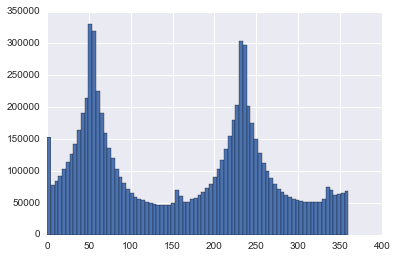

In [263]:
plt.hist(df['angle_abs'], 80, range=[0, 360]); # Two prominent directions that's reverse of each other

## Modelling

In [19]:
## Linear Regression
#from sklearn import cross_validation
#from sklearn import linear_model
#
#k_fold = cross_validation.KFold(n=5, n_folds=5)
#lr = linear_model.LinearRegression()

from sklearn import metrics
import time
# Get the right feature columns
coord_features = ['h_dist', 'm_dist', 'HPCP2'] # Include angle_abs?
for coord_feat in coord_features:
    dummy_cols.append(coord_feat)
features = dummy_cols

In [44]:
X = df[features]
y = df.fare_amount
# y = df['sum']

# import math
# def roundup(x):
#     return int(math.ceil(x / 10.0)) * 10
# def roundminute(x):
#     return int(math.ceil(x / 60.0))
# y = df.trip_time_in_secs.map(roundminute)

#y = df.fare_amount.map(np.log)

# Split data into train and test sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [20]:
X = np.array(df[features])
y = np.array(df['shareability'])
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
from sklearn.linear_model import LogisticRegression

start = time.time()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
end = time.time()
print(logreg.score(X, y))
y_pred = logreg.predict(X_test)
from sklearn import metrics
print('Accuracy (log Reg.) =', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC (log Reg.) =', metrics.roc_auc_score(y_test, y_pred))
print('Time (log Reg.) =', end - start)

0.766911317399
Accuracy (log Reg.) = 0.767271633024
ROC AUC (log Reg.) = 0.76209097376
Time (log Reg.) = 109.687000036


In [331]:
from sklearn.metrics import confusion_matrix
y_pred = logreg.predict(X_test)
y = np.array(y)
class_names = np.unique(y)

cm = confusion_matrix(y_test, y_pred)
cm

array([[983875, 264541],
       [219385, 609174]])

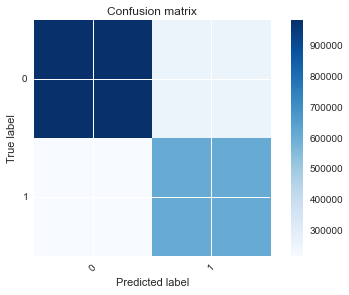

In [334]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure()
plot_confusion_matrix(cm)

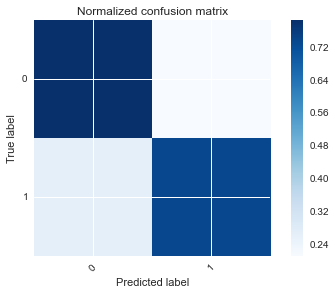

In [340]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [ ]:
from sklearn import cross_validation
k_fold = cross_validation.KFold(len(y), n_folds=5, shuffle=True)
for train_index, test_index in k_fold:
    logreg.fit(X.iloc[train_index], y[train_index])
    print("score1: ", logreg.score(X[test_index], y[test_index]))
    print("score2: ", metrics.accuracy_score(X[test_index], y[test_index]))
    print("score3: ", metrics.roc_auc_score(X[test_index], y[test_index]))

In [328]:
# Fit on entire data
logreg = LogisticRegression()
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [21]:
# Extra Trees
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
start = time.time()
xrf = ExtraTreesClassifier(max_features='auto', min_samples_leaf=8000, bootstrap=True, oob_score=True, n_jobs=-1)
xrf.fit(X_train, y_train)
end = time.time()
y_pred = xrf.predict(X_test)
print('Time (xRF) =', end - start)
#print('Score (xRF) =', xrf.score(X_test, y_test))
print(roc_auc_score(y_pred, y_test))
print('oob score(xRF) =', xrf.oob_score_)

Time (xRF) = 88.0859999657
0.768608827971
oob score(xRF) = 0.760812483159


C:\Users\95780\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:379: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [25]:
# RF Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
start = time.time()
rf = RandomForestClassifier(max_features='auto', min_samples_leaf=8000, bootstrap=True, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
end = time.time()
y_pred = rf.predict(X_test)
print('Time (RF) =', end - start)
#print('Score (RF) =', xrf.score(X_test, y_test))
print(roc_auc_score(y_pred, y_test))
print('oob score(RF) =', rf.oob_score_)

KeyboardInterrupt: 

In [26]:
rf = RandomForestClassifier(max_features='auto', min_samples_leaf=8000, bootstrap=True, oob_score=True, n_jobs=-1)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=8000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [27]:
# RF # Model file too large, 80mb
from sklearn.ensemble import RandomForestRegressor
start = time.time()
rf = RandomForestRegressor(max_features='auto', min_samples_leaf=8000, oob_score=True, n_jobs=-1)
rf.fit(X, y)
end = time.time()
print("Random Forest", end - start, rf.score(X,y), rf.oob_score_)

Random Forest 562.555000067 0.768917934889


In [33]:
from sklearn import cross_validation
k_fold = cross_validation.KFold(len(y), n_folds=5, shuffle=True)
for train_index, test_index in k_fold:
    rf.fit(X.iloc[train_index], y.iloc[train_index])
    print("score: ", rf.score(X.iloc[test_index], y.iloc[test_index]))

score:  0.767913874064
score:  0.76635609283
score:  0.765997883657
score:  0.765524035474
score:  0.76670063403


In [223]:
# Extra Trees
from sklearn.ensemble import ExtraTreesRegressor
start = time.time()
xrf = ExtraTreesRegressor(max_features='auto', min_samples_leaf=8000, bootstrap=True, oob_score=True, n_jobs=-1)
xrf.fit(X, y)
end = time.time()
print('Time (xRF) =', end - start)
print('Score (xRF) =', xrf.score(X, y))
print('oob score(xRF) =', xrf.oob_score_)

Time (xRF) = 450.845999956
Score (xRF) = 0.584682643751
oob score(xRF) = 0.544767589048


In [43]:
from sklearn import cross_validation
k_fold = cross_validation.KFold(len(y), n_folds=5, shuffle=True)
for train_index, test_index in k_fold:
    xrf.fit(X.iloc[train_index], y.iloc[train_index])
    print("score: ", xrf.score(X.iloc[test_index], y.iloc[test_index]))

score:  0.58174704456
score:  0.579998831385
score:  0.579345142963
score:  0.580546813425
score:  0.581256894151


In [ ]:
#y_pred = clf.predict(X_test)
#print('RSQR (xRF) =', metrics.r2_score(X, y))
#print('RMSE (xRF) =', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(xrf, X, y, cv=5, n_jobs=-1)
print(score.mean())

Feature ranking:
1. feature 90 (0.607572)
2. feature 91 (0.277116)
3. feature 4 (0.030414)
4. feature 65 (0.013580)
5. feature 64 (0.012487)
6. feature 72 (0.010505)
7. feature 1 (0.009426)
8. feature 73 (0.008458)
9. feature 87 (0.006157)
10. feature 59 (0.004030)
11. feature 86 (0.003820)
12. feature 0 (0.002132)
13. feature 18 (0.001166)
14. feature 3 (0.001146)
15. feature 45 (0.001141)
16. feature 23 (0.001045)
17. feature 50 (0.000963)
18. feature 85 (0.000852)
19. feature 75 (0.000694)
20. feature 26 (0.000686)
21. feature 53 (0.000660)
22. feature 35 (0.000504)
23. feature 8 (0.000445)
24. feature 74 (0.000443)
25. feature 2 (0.000435)
26. feature 52 (0.000331)
27. feature 88 (0.000308)
28. feature 25 (0.000292)
29. feature 89 (0.000275)
30. feature 34 (0.000228)
31. feature 49 (0.000206)
32. feature 37 (0.000206)
33. feature 22 (0.000206)
34. feature 10 (0.000201)
35. feature 51 (0.000201)
36. feature 24 (0.000185)
37. feature 7 (0.000173)
38. feature 11 (0.000158)
39. feature

AssertionError: incompatible sizes: argument 'height' must be length 93 or scalar

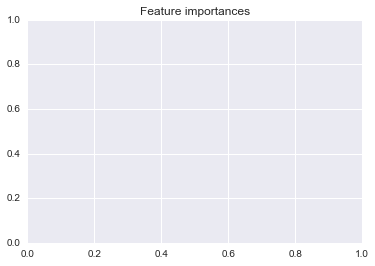

In [345]:
importances = xrf.feature_importances_
std = np.std([tree.feature_importances_ for tree in xrf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [222]:
# Fit a linear regression model
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
start = time.time()
linreg.fit(X_train, y_train)
end = time.time()

# Make predictions on testing set and calculate accuracy
y_pred = linreg.predict(X_test)
from sklearn import metrics
print('RSQR (Linear Reg.) =', metrics.r2_score(y_test, y_pred))
print('RMSE (Linear Reg.) =', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Time (Linear Reg.) =', end - start)

RSQR (Linear Reg.) = 0.52731941232
RMSE (Linear Reg.) = 4.23602750221
Time (Linear Reg.) = 51.4479999542


In [53]:
# K-fold CV
#X = np.array(X)
#y = np.array(y)
from sklearn import cross_validation, datasets, linear_model
lm_cv = LinearRegression(n_jobs=-1)
k_fold = cross_validation.KFold(len(y), n_folds=5, shuffle=True)
for train_index, test_index in k_fold:
    lm_cv.fit(X[train_index], y[train_index])
    print("score: ", lm_cv.score(X[test_index], y[test_index]))

score:  0.746011099678
score:  0.745836969771
score:  0.74621381007
score:  0.745822737361
score:  0.747924314083


In [41]:
from sklearn.cross_validation import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(len(y), n_folds=2)

print(kf)  

for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


sklearn.cross_validation.KFold(n=4, n_folds=2, shuffle=False, random_state=None)
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


In [64]:
# Conduct a grid search for the best tree depth over multiple parameters
from sklearn.grid_search import GridSearchCV
ctree = DecisionTreeRegressor(random_state=1)
depth_range = range(9, 12)
features_range = np.arange(0.7, 1, 0.1).tolist()
param_grid = dict(max_depth=depth_range, max_features=features_range)
grid = GridSearchCV(ctree, param_grid, cv=5, scoring='mean_squared_error')
grid.fit(X, y)

KeyboardInterrupt: 

In [ ]:
# Get the best estimator
best = grid.best_estimator_
print(best)
print(cross_val_score(best, X, y, cv=10, scoring='mean_squared_error').mean())


In [27]:
import cPickle
# save the classifier
with open('nyctaxi_rf.pkl', 'wb') as fid:
    cPickle.dump(rf, fid, protocol=2)        

In [ ]:
# load it again
with open('nyctaxi_linreg.pkl', 'rb') as fid:
    linreg_loaded = cPickle.load(fid)
y_pred = linreg_loaded.predict(X_test)

In [55]:
df2 = df
df2['prev_weekday'], df2['prev_hour'] = np.vectorize(getPreviousHour)(df2.pickup_weekday, df2.pickup_hour)

In [60]:
left_on = ['pickup_longitude2', 'pickup_latitude2', 'dropoff_longitude2', 'dropoff_latitude2', 'prev_weekday', 'prev_hour']
right_on = ['pickup_longitude2', 'pickup_latitude2', 'dropoff_longitude2', 'dropoff_latitude2', 'pickup_weekday', 'pickup_hour']
df2 = pd.merge(df2, df_freq, how='left', left_on=left_on, right_on=right_on).fillna(0)
df2.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,prev_weekday,prev_hour,pickup_weekday_y,pickup_hour_y,count
0,1B5C0970F2AE8CFFBA8AE4584BEAED29,D961332334524990D1BBD462E2EFB8A4,CMT,1,N,2013-02-08 23:35:14,2013-02-08 23:42:58,1,463,0.8,...,0,0,0,0,1,4,22,4,22,40
1,890699222C47C09FBC898758CEC69762,6318C3AEC02248928C3345B5805EB905,CMT,1,N,2013-02-08 08:56:54,2013-02-08 08:59:43,1,168,1.0,...,0,0,0,0,0,4,7,4,7,61
2,74B7D835C2CD98606D5256DA8A38E045,D5E278C918256D1F97680A1F04D290E0,CMT,1,N,2013-02-08 09:37:02,2013-02-08 09:50:50,1,828,2.1,...,0,0,0,0,0,4,8,4,8,19
3,4003B8478418FEC5D761E2F37602769B,0B766F1054A5C16D86BC023858BD8143,CMT,1,N,2013-02-08 19:31:25,2013-02-08 19:46:23,1,897,3.3,...,1,0,0,0,0,4,18,4,18,25
4,FA5337E245DE9B2E124AFA735B41B4DF,6E6B7D73303D5AE3808A9ABF4D3FF65B,CMT,1,N,2013-02-07 22:02:30,2013-02-07 22:06:18,1,227,0.7,...,0,0,0,1,0,3,21,3,21,68


In [70]:
df2 = pd.merge(df2, df_avg_fare, how='left', left_on=left_on, right_on=right_on).fillna(0)
df2.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,pickup_hour_22,pickup_hour_23,prev_weekday,prev_hour,pickup_weekday_y,pickup_hour_y,count,pickup_weekday,pickup_hour,mean
0,1B5C0970F2AE8CFFBA8AE4584BEAED29,D961332334524990D1BBD462E2EFB8A4,CMT,1,N,2013-02-08 23:35:14,2013-02-08 23:42:58,1,463,0.8,...,0,1,4,22,4,22,40,4,22,7.150000
1,890699222C47C09FBC898758CEC69762,6318C3AEC02248928C3345B5805EB905,CMT,1,N,2013-02-08 08:56:54,2013-02-08 08:59:43,1,168,1.0,...,0,0,4,7,4,7,61,4,7,5.868852
2,74B7D835C2CD98606D5256DA8A38E045,D5E278C918256D1F97680A1F04D290E0,CMT,1,N,2013-02-08 09:37:02,2013-02-08 09:50:50,1,828,2.1,...,0,0,4,8,4,8,19,4,8,12.000000
3,4003B8478418FEC5D761E2F37602769B,0B766F1054A5C16D86BC023858BD8143,CMT,1,N,2013-02-08 19:31:25,2013-02-08 19:46:23,1,897,3.3,...,0,0,4,18,4,18,25,4,18,16.860000
4,FA5337E245DE9B2E124AFA735B41B4DF,6E6B7D73303D5AE3808A9ABF4D3FF65B,CMT,1,N,2013-02-07 22:02:30,2013-02-07 22:06:18,1,227,0.7,...,1,0,3,21,3,21,68,3,21,4.625000


In [71]:
#features.append('count')
features.append('mean')
X = df2[features]
y = df2.fare_amount
#y = df.fare_amount.map(np.log)

# Split data into train and test sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [72]:
# Fit a linear regression model
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
start = time.time()
linreg.fit(X_train, y_train)
end = time.time()

# Make predictions on testing set and calculate accuracy
y_pred = linreg.predict(X_test)
from sklearn import metrics
print('RSQR (Linear Reg.) =', metrics.r2_score(y_test, y_pred))
print('RMSE (Linear Reg.) =', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Time (Linear Reg.) =', end - start)

RSQR (Linear Reg.) = 0.7532541289
RMSE (Linear Reg.) = 2.34901911904
Time (Linear Reg.) = 39.5490000248


In [73]:
# Extra Trees
from sklearn.ensemble import ExtraTreesRegressor
start = time.time()
xrf = ExtraTreesRegressor(max_features='auto', min_samples_leaf=8000, bootstrap=True, oob_score=True, n_jobs=-1)     
for train_index, test_index in k_fold:
    xrf.fit(X.iloc[train_index], y.iloc[train_index])
    print("score: ", xrf.score(X.iloc[test_index], y.iloc[test_index]))
end = time.time()
print('Time (xRF) =', end - start)

score:  0.790077597912
score:  0.787229826216
score:  0.787766036823
score:  0.786225788953
score:  0.78703262348
Time (xRF) = 1963.43300009
